<a href="https://colab.research.google.com/github/daretoshare/daretoshare/blob/master/Model_Risk_%26_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [288]:
# Setup
!pip install imgaug==0.2.5
!pip install lime eli5 scikit-image xgboost keras tensorflow --upgrade
!pip install scikit-learn==0.20
!pip install shap==0.24
!pio install numpy==1.19.2 

# Download files
!rm -f helpers.py*
!wget https://raw.githubusercontent.com/klemag/pydata_nyc2018-intro-to-model-interpretability/master/helpers.py

Requirement already up-to-date: lime in /usr/local/lib/python3.6/dist-packages (0.2.0.1)
Requirement already up-to-date: eli5 in /usr/local/lib/python3.6/dist-packages (0.10.1)
Requirement already up-to-date: scikit-image in /usr/local/lib/python3.6/dist-packages (0.17.2)
Requirement already up-to-date: xgboost in /usr/local/lib/python3.6/dist-packages (1.3.0.post0)
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.0)
/bin/bash: pio: command not found
--2020-12-19 09:35:01--  https://raw.githubusercontent.com/klemag/pydata_nyc2018-intro-to-model-interpretability/master/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1112 (1.1K

# Introduction to Model Interpretability

Loading libraries


In [289]:
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# From Logistic to XGB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

###  Credit Card Payment Default Dataset

This is an open source dataset available in UCI repository [Link](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

In [290]:
df = pd.read_csv("/content/UCI_Credit_Card.csv", sep=",")

In [291]:
df.head()

ID  LIMIT_BAL  SEX  ...  PAY_AMT5  PAY_AMT6  default payment next month
0   1      20000    2  ...         0         0                           1
1   2     120000    2  ...         0      2000                           1
2   3      90000    2  ...      1000      5000                           0
3   4      50000    2  ...      1069      1000                           0
4   5      50000    1  ...       689       679                           0

[5 rows x 25 columns]

In [292]:
df.rename(columns = {'default payment next month':'default', }, inplace = True) 
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  ...  PAY_AMT4  PAY_AMT5  PAY_AMT6  default
0   1      20000    2          2  ...         0         0         0        1
1   2     120000    2          2  ...      1000         0      2000        1
2   3      90000    2          2  ...      1000      1000      5000        0
3   4      50000    2          2  ...      1100      1069      1000        0
4   5      50000    1          2  ...      9000       689       679        0

[5 rows x 25 columns]

In [293]:
df.default.value_counts(normalize=True)*100

0    77.88
1    22.12
Name: default, dtype: float64

The dataset is imbalanced, we will need to keep that in mind when building our models!

In [294]:
y = df["default"]
X = df.drop("default", axis=1)

Here is the metadata

1. `ID`: ID of each client
2. `LIMIT_BAL`: Amount of given credit in NT dollars (includes individual and family/supplementary credit
3. `SEX`: Gender (1=male, 2=female)
4. `EDUCATION`: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
5. `MARRIAGE`: Marital status (1=married, 2=single, 3=others)
6. `AGE`: Age in years
7. `PAY_0`: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
8. `PAY_2`: Repayment status in August, 2005 (scale same as above)
9. `PAY_3`: Repayment status in July, 2005 (scale same as above)
10. `PAY_4`: Repayment status in June, 2005 (scale same as above)
11. `PAY_5`: Repayment status in May, 2005 (scale same as above)
12. `PAY_6`: Repayment status in April, 2005 (scale same as above)
13. `BILL_AMT1`: Amount of bill statement in September, 2005 (NT dollar)
14. `BILL_AMT2`: Amount of bill statement in August, 2005 (NT dollar)
15. `BILL_AMT3`: Amount of bill statement in July, 2005 (NT dollar)
16. `BILL_AMT4`: Amount of bill statement in June, 2005 (NT dollar)
17. `BILL_AMT5`: Amount of bill statement in May, 2005 (NT dollar)
18. `BILL_AMT6`: Amount of bill statement in April, 2005 (NT dollar)
19. `PAY_AMT1`: Amount of previous payment in September, 2005 (NT dollar)
20. `PAY_AMT2`: Amount of previous payment in August, 2005 (NT dollar)
21. `PAY_AMT3`: Amount of previous payment in July, 2005 (NT dollar)
22. `PAY_AMT4`: Amount of previous payment in June, 2005 (NT dollar)
23. `PAY_AMT5`: Amount of previous payment in May, 2005 (NT dollar)
24. `PAY_AMT6`: Amount of previous payment in April, 2005 (NT dollar)
25. `default.payment.next.month`: Default payment (1=yes, 0=no)





In [295]:
X.dtypes

ID           int64
LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
dtype: object

In [296]:
# Lets separate numerical and categorical features 
num_features = ["LIMIT_BAL", "AGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
                "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1",
                "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]

cat_features = ["SEX", "MARRIAGE", "EDUCATION"]

We'll define a new `ColumnTransformer` object that keeps our numerical 
features and apply one hot encoding on our categorical features. That will allow us to create a clean pipeline that includes both features engineering (one hot encoding here) and training the model

In [297]:
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])

Now we can define our 4 models as sklearn `Pipeline` object, containing our preprocessing step and training of one given algorithm.

In [298]:
# Logistic Regression
lr_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42))])

# Decision Tree
dt_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", DecisionTreeClassifier(class_weight="balanced"))])

# Random Forest
rf_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", RandomForestClassifier(class_weight="balanced", n_estimators=100, n_jobs=-1))])

# XGBoost
xgb_model = Pipeline([("preprocessor", preprocessor), 
                      # Add a scale_pos_weight to make it balanced
                      ("model", XGBClassifier(scale_pos_weight=(1 - y.mean()), n_jobs=-1))])

Let's split the data into training and test sets.

In [299]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

We're good to go!

## Eli5 to intepret the models

### First, Logistic Regression

First let's fine tune our logistic regression and evaluate its performance.

In [300]:
gs = GridSearchCV(lr_model, {"model__C": [1, 1.3, 1.5]}, n_jobs=-1, cv=5, scoring="accuracy")
gs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BIL...alty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__C': [1, 1.3, 1.5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

Get the best params and then score

In [301]:
print(gs.best_params_)
print(gs.best_score_)

{'model__C': 1.5}
0.6734285714285714


In [302]:
lr_model.set_params(**gs.best_params_)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BIL...alty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

Now we can fit the model on the whole training set and calculate accuracy on the test set.

In [303]:
lr_model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BIL...alty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

Generate predictions

In [304]:
y_pred = lr_model.predict(X_test)

In [305]:
accuracy_score(y_test, y_pred)

0.6225555555555555

In [306]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.61      0.72      7009
           1       0.33      0.66      0.43      1991

   micro avg       0.62      0.62      0.62      9000
   macro avg       0.59      0.63      0.58      9000
weighted avg       0.74      0.62      0.65      9000



Let's use `eli5` to visualise the weights associated to each feature:

In [307]:
import eli5
eli5.show_weights(lr_model.named_steps["model"])

Y=1 meaning the person will default in payment. Weights are relative importance of the variable 

X1, X2 etc. are not understandable and we need to map them to the proper variable name after OHE for better redability 

In [308]:
preprocessor = lr_model.named_steps["preprocessor"]
ohe_categories = preprocessor.named_transformers_["categorical"].categories_
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]
all_features = num_features + new_ohe_features

Great, so now we have a nice list of columns after processing. Let's visualise the data in a dataframe just for sanity check:

In [309]:
pd.DataFrame(lr_model.named_steps["preprocessor"].transform(X_train), columns=all_features).head()

LIMIT_BAL   AGE  PAY_0  ...  EDUCATION__4  EDUCATION__5  EDUCATION__6
0   160000.0  32.0    0.0  ...           0.0           0.0           0.0
1   100000.0  30.0    0.0  ...           0.0           0.0           0.0
2    80000.0  29.0    0.0  ...           0.0           0.0           0.0
3    20000.0  27.0    0.0  ...           0.0           0.0           0.0
4    50000.0  30.0   -2.0  ...           0.0           0.0           0.0

[5 rows x 33 columns]

Global (overall model) interpretation

In [310]:
eli5.show_weights(lr_model.named_steps["model"], feature_names=all_features)

What do you make out of it?

In [311]:
#ELI5 is a nicer way to display these coefs
lr_model.named_steps['model'].coef_[0][2]

0.09798351615682285

We can also use `eli5` to explain a specific prediction, let's pick a row in the test data:

In [312]:
#20465, 2000
i = 1
X_test.iloc[[i]]

ID  LIMIT_BAL  SEX  EDUCATION  ...  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6
17618  17619      80000    2          1  ...      4844         0         0         0

[1 rows x 24 columns]

In [313]:
y_test.iloc[i]

1

What do you think?

In [314]:
eli5.show_prediction(lr_model.named_steps["model"], 
                     lr_model.named_steps["preprocessor"].transform(X_test)[i],
                     feature_names=all_features, show_feature_values=True)

### Decision Tree

In [315]:
gs = GridSearchCV(dt_model, {"model__max_depth": [3, 5, 7], 
                             "model__min_samples_split": [2, 3, 5]}, 
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BIL...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__max_depth': [3, 5, 7], 'model__min_samples_split': [2, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Let's see our best parameters and score

In [316]:
print(gs.best_params_)
print(gs.best_score_)

{'model__max_depth': 5, 'model__min_samples_split': 2}
0.7679047619047619


Significant improvement!

In [317]:
dt_model.set_params(**gs.best_params_)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BIL...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [318]:
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

In [319]:
accuracy_score(y_test, y_pred)

0.7811111111111111

In [320]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      7009
           1       0.50      0.54      0.52      1991

   micro avg       0.78      0.78      0.78      9000
   macro avg       0.69      0.70      0.69      9000
weighted avg       0.79      0.78      0.78      9000



LIMITATION: For DT, ELI5 would just provide the global feature importance. However, you get the tree structure as a visualization

In [321]:
eli5.show_weights(dt_model.named_steps["model"], feature_names=all_features)

PAY_0 is the key! Makes total sense! You still get the direction at the individual prediction level

In [ ]:
eli5.show_prediction(dt_model.named_steps["model"], 
                     dt_model.named_steps["preprocessor"].transform(X_test)[i],
                     feature_names=all_features, show_feature_values=True)

Here the explanation for a single prediction is calculated by following the decision path in the tree, and adding up contribution of each feature from each node crossed into the overall probability predicted.

`eli5` can also be used to explain black box models, but we will use `Lime` and `SHAP` for our two last models instead.

## LIME to generate local intepretations for relatively complex models

LIME stands for `Local Interpretable Model-Agnostic Explanations`. We can use it with any model we've built in order to explain why it took a specific decision for a given observation. To do so, LIME creates a dataset in the locality of our observation by perturbating the different features. Then it fits a local linear model on this data and uses the weights on each feature to provide an explanation.

### with a Random Forest

In [322]:
gs = GridSearchCV(rf_model, {"model__max_depth": [10, 15], 
                             "model__min_samples_split": [5, 10]}, 
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BIL...ators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__max_depth': [10, 15], 'model__min_samples_split': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Let's see our best parameters and score

In [324]:
print(gs.best_params_)
print(gs.best_score_)

{'model__max_depth': 15, 'model__min_samples_split': 5}
0.8066666666666666


In [325]:
rf_model.set_params(**gs.best_params_)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BIL...ators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False))])

In [326]:
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8024444444444444

In [327]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      7009
           1       0.56      0.48      0.52      1991

   micro avg       0.80      0.80      0.80      9000
   macro avg       0.71      0.69      0.70      9000
weighted avg       0.79      0.80      0.80      9000



We can look at the features importance with Eli5 first:

In [328]:
eli5.show_weights(rf_model.named_steps["model"], 
                  feature_names=all_features)

We can explain roughly what our model seems to focus on mostly. We also get the standard deviation of feature importance accross the multiple trees in our ensemble.

In [329]:
eli5.show_prediction(rf_model.named_steps["model"], 
                     rf_model.named_steps["preprocessor"].transform(X_test)[i],
                     feature_names=all_features, show_feature_values=True)

### Let's train our XGB model as well

In [330]:
gs = GridSearchCV(xgb_model, {"model__max_depth": [5, 10],
                              "model__min_child_weight": [5, 10],
                              "model__n_estimators": [25]},
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:41:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BIL...e=None, tree_method=None, use_label_encoder=True,
       validate_parameters=None, verbosity=None))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__max_depth': [5, 10], 'model__min_child_weight': [5, 10], 'model__n_estimators': [25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Let's see our best parameters and score.

In [331]:
print(gs.best_params_)
print(gs.best_score_)
xgb_model.set_params(**gs.best_params_)
xgb_model.fit(X_train, y_train)

{'model__max_depth': 5, 'model__min_child_weight': 5, 'model__n_estimators': 25}
0.8209047619047619
[09:41:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BIL...
       tree_method='exact', use_label_encoder=True, validate_parameters=1,
       verbosity=None))])

Generate predictions

In [332]:
y_pred = xgb_model.predict(X_test)

In [333]:
accuracy_score(y_test, y_pred)

0.8163333333333334

In [334]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7009
           1       0.67      0.33      0.44      1991

   micro avg       0.82      0.82      0.82      9000
   macro avg       0.75      0.64      0.67      9000
weighted avg       0.80      0.82      0.79      9000



In [335]:
eli5.show_weights(xgb_model.named_steps["model"], 
                  feature_names=all_features)

### Create an explainer

In order to explain why the model classifies invidividual observations as class 0 or 1, we are going to use the `LimeTabularExplainer` from the library `lime`, this is the main explainer to use for tabular data. Lime also provides an explainer for text data, for images and for time-series.

When using the tabular explainer, we need to provide our training set as parameter so that `lime` can compute statistics on each feature, either `mean` and `std` for numerical features, or frequency of values for categorical features. Those statistics are used to scale the data and generate new perturbated data to train our local linear models on.

In [336]:
from lime.lime_tabular import LimeTabularExplainer
import matplotlib. pyplot as plt
import numpy as np

In [337]:
rf_model = RandomForestClassifier(max_depth=15, min_samples_split=5, random_state=0, n_estimators=10)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Global Importance using Feature Importance


Text(0.5, 0, 'Relative Importance')

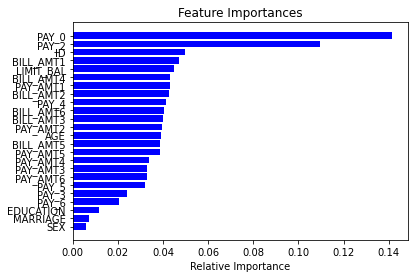

In [338]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')


In [339]:
i = 2000

# First we can check the row in the non-processed dataset
print(X_test.iloc[i])


ID            20466
LIMIT_BAL    190000
SEX               1
EDUCATION         1
MARRIAGE          2
AGE              25
PAY_0             0
PAY_2             0
PAY_3             2
PAY_4             0
PAY_5             0
PAY_6             0
BILL_AMT1      3173
BILL_AMT2      5270
BILL_AMT3      5040
BILL_AMT4      6050
BILL_AMT5      6447
BILL_AMT6      7339
PAY_AMT1       2323
PAY_AMT2          0
PAY_AMT3       1103
PAY_AMT4        500
PAY_AMT5       1000
PAY_AMT6        400
Name: 20465, dtype: int64


In [340]:
print(f"""\
* True label: {y_test.iloc[i]}
* LR: {lr_model.predict_proba(X_observation)[0]}
* DT: {dt_model.predict_proba(X_observation)[0]}
* RF: {rf_model.predict_proba(X_observation)[0]}
* XGB: {xgb_model.predict_proba(X_observation)[0]}""")

* True label: 0
* LR: [0.65881372 0.34118628]
* DT: [0.63177593 0.36822407]
* RF: [0.79421329 0.20578671]
* XGB: [0.9483606  0.05163938]


Create an explainer

In [341]:
explainer= LimeTabularExplainer(training_data=np.array(X_train),
                                mode='classification', 
                                feature_names=list(X_train.columns),
                                training_labels=np.array(y_train),
                                random_state=12)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Local Explanation


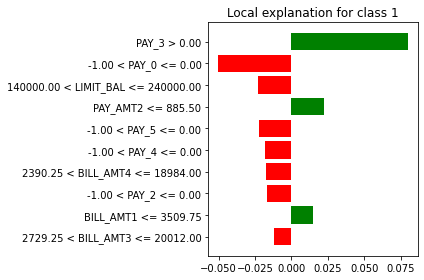

In [342]:
exp = explainer.explain_instance(X_test.iloc[i], rf_model.predict_proba, num_features=10)
exp.as_pyplot_figure()
plt.tight_layout()

In [343]:
exp.show_in_notebook(show_table=True, show_all=True)

In [344]:
exp = explainer.explain_instance(X_test.iloc[731], rf_model.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

#### Explain new observations

We'll create a variable called `observation` that contains our ith observation in the test dataset.

In [345]:
i = 450

X_observation = X_test.iloc[[i], :]
X_observation

ID  LIMIT_BAL  SEX  EDUCATION  ...  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6
2318  2319     360000    2          1  ...      3000         0         0         0

[1 rows x 24 columns]

You can also save the explanation to an html file with `save_to_file` to share it.

In [346]:
exp.save_to_file("explanation.html")

LIME is fitting a linear model on a local perturbated dataset. You can access the coefficients, the intercept and the R squared of the linear model by calling respectively `.local_exp`, `.intercept` and `.score` on your explanation.

In [347]:
print(exp.local_exp)
print(exp.intercept)
print(exp.score)

{1: [(1, 0.06661225335331462), (6, -0.04963158693758235), (7, -0.02748192535546066), (8, -0.018441459767051752), (15, -0.01811780584520382), (10, -0.01751445459672401), (13, -0.016534963606037106), (12, -0.015327532537813297), (9, -0.014779801582503766), (14, -0.01431712127596599)]}
{1: 0.36407309610421146}
0.07923089849441245


If your R-squared is low, the linear model that LIME fitted isn't a great approximation to your model, which means you should not rely too much on the explanation it provides.

## More local interpretation with SHAP

In [348]:
import shap
# Need to load JS vis in the notebook
shap.initjs() 

SHAP has a generic explainer that works for any model and a TreeExplainer optimised for tree based models. Here we will focus on the `TreeExplainer` with our XGB model (the hardest to intepret)

In [349]:
explainer = shap.TreeExplainer(xgb_model.named_steps["model"])

In order to compute the shapley values with the tree explainer, we need to call the `shap_values` methods passing a dataset. That can be quite computationally expensive, so we will only pass 1000 samples picked at random.

In [350]:
observations = xgb_model.named_steps["preprocessor"].transform(X_train.sample(1000, random_state=12))
shap_values = explainer.shap_values(observations)

Now we can start visualising our explanations using the `force_plot` function from the shap package passing our first shap_value (we also need to pass `explainer.expected_value` which is the base value).

In [352]:
# 20
shap.initjs() 
i = 20
shap.force_plot(explainer.expected_value, shap_values[i], 
                features=observations[i], feature_names=all_features)

This explanation shows how each feature contributes to shifting the prediction from the base value to the output value of the model either by decreasing or increasing the probability of our class.

We can also visualise all points in our dataset at once with a given class by passing all explanations for that class to `force_plot`

In [353]:
shap.initjs() 
shap.force_plot(explainer.expected_value, shap_values,
                features=observations, feature_names=all_features)

We can see our 1000 samples on the x axis. The y-axis corresponds to the same scale we were looking at before, where blue values corresponds to the probability decreasing, red increasing. Hover with your mouse on a point to see the main features impacting a given observation. You can also use the drop down on the left to visualise the impact of specific features, for example duration only.

Another interesting plot that we can generate with SHAP is the `summary_plot`, it can be seen as a feature importance plot with more meaningful insights. 
The colour corresponds to the value of the feature and the x axis corresponds to the SHAP value, meaning the impact on the probability. 

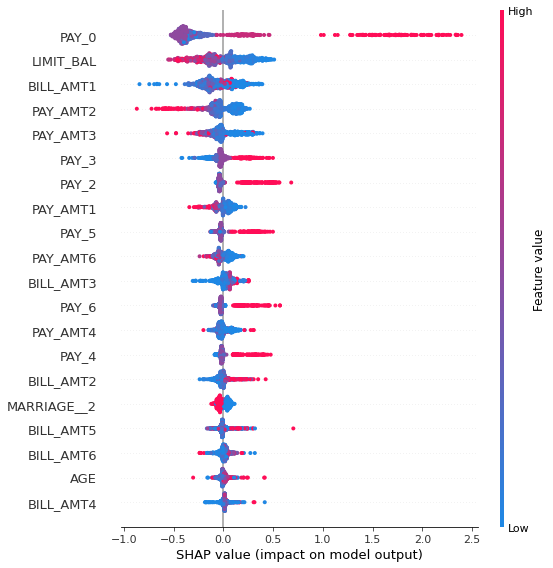

In [354]:
shap.initjs() 
shap.summary_plot(shap_values, features=observations, feature_names=all_features)

That's better than the built-in feature importance on RandomForest because not only we can see what features are important but also how they affect our predictions.

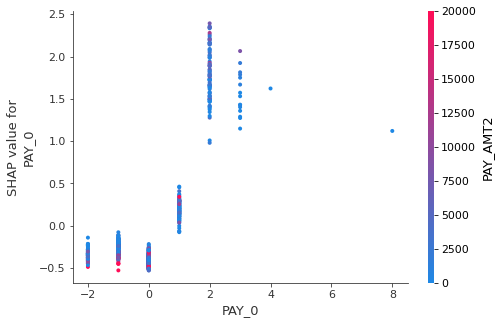

In [355]:
shap.dependence_plot("PAY_0", shap_values, 
                     pd.DataFrame(observations, columns=all_features))

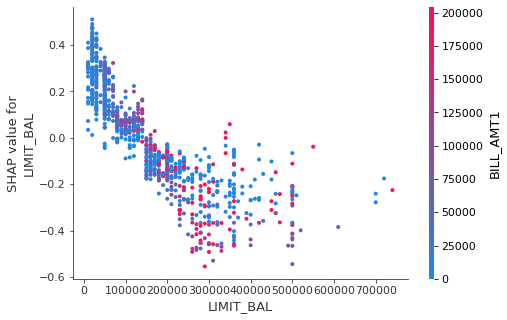

In [356]:
shap.dependence_plot("LIMIT_BAL", shap_values, 
                     pd.DataFrame(observations, columns=all_features))